In [1]:
import os
import cv2
import keras
import numpy as np
import pandas as pd
import tensorflow as tf
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras.optimizers import Adam
from keras.layers import GlobalAveragePooling2D, Dense, Conv2D, Activation, Dropout, GlobalMaxPooling2D, Concatenate, MaxPooling2D
from keras.models import Model
import matplotlib.pyplot as plt
import albumentations
from scipy.special import softmax as softmax
import time

%load_ext autoreload
%autoreload 2
%matplotlib inline

import severstal_utils
from severstal_utils import build_rles, DataGenerator, load_severstal_data
from unet import Unet

SEED=2019
severstal_utils.seed_everything(SEED)

#### GPU with memory growth
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True
# sess = tf.Session(config=config)
# keras.backend.set_session(sess)

#### CPU Only
# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID" 
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


Segmentation Models: using `keras` framework.


In [3]:
base_path = './data/'
custom_masks_path = base_path + 'nbr_faultlocs_crop320_rounded32.pkl'
FOLD = 1
NUM_FOLDS = 25
fault_idx_keys = ['fault1_320_50', 'fault2_320_50', 'fault3_320_50', 'fault4_320_50', 'nofault']
train_sampling_weights = [0.1, 0.1, 0.4, 0.1, 0.3] # No fault index last
val_sampling_weights = [0.2, 0.2, 0.2, 0.2, 0.2]
train_df, mask_df, train_idx, val_idx = load_severstal_data(base_path, 
                                                            seed=SEED, 
                                                            masks_path=custom_masks_path,
                                                            fold=FOLD, num_folds=NUM_FOLDS)
print(len(train_idx), len(val_idx))

12066 502


In [4]:
BACKBONE = 'efficientnetb4'
down_layername = 'top_activation'
auxseg_layername = 'decoder_stage4b2_swish' # changes with activation name
layer_names = {'segmentation': 'masks', 
               'classification': 'classifier', 
               'auxilliary': 'auxilliary_segmentation'}

decoder_filters=(256, 128, 128, 64, 64)
decoder_block_type = 'transpose3layer'
TRAIN_DIM = (256, 320)

loadmodelname = 'None'
expname = 'efub4_nbr320_tripleloss_combosegdense_fold3'
dummymode = False # Set this while making modifications
if dummymode: 
    train_idx = train_idx[:1000]
    val_idx = val_idx[:1000]
    expname += '_dummy'
savemodelname = expname + '.h5'
logFile =  'log_' + expname + '.txt'
dice_alpha = 1.0
LR_FREEZE = [3e-3, 1e-3] # Start and end values of linear schedule
LR_FULL = [1e-3, 1e-4]
WEIGHT_DECAY = 1e-3
EPOCHS_FREEZE=20
EPOCHS_FULL=30
train_mean_std = (0.39531398, 0.1560004)  # without black regions 

BATCH_SIZE = 16

In [5]:
with open(logFile, 'a+') as log:
    log.write('|---------------------------------|---------------------------------------------TRAIN------------------------------------------|---------------------------------------------VALID------------------------------------------|----------------------------------------|-----------------------------------------|\n')
    log.write('|       |    |         |          |---------Class 1----------------Class 2----------------Class 3----------------Class 4-------|---------Class 1----------------Class 2----------------Class 3----------------Class 4-------|---------Time------|         |          |         |          |         |          |\n')
    log.write('| lr_3  | ep |  loss   | val-loss |  TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice |  TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice   TP  FP  FN  TN  Dice |        HH  MM     |  m-los  |val-mloss |  c-loss |val-closs |  a-loss |val-aloss |\n')
    log.write('|-------|----|---------|----------|--------------------------------------------------------------------------------------------|--------------------------------------------------------------------------------------------|-------------------|---------|----------|---------|----------|---------|----------|\n')
#              |-1.785 | 20 | 0.39153 | 0.39153  | 000 000 000 000 0.000  000 000 000 000 0.000  000 000 000 000 0.000  000 000 000 000 0.000 | 000 000 000 000 0.000  000 000 000 000 0.000  000 000 000 000 0.000  000 000 000 000 0.000 |        20  59     |

In [6]:
def get_data_generators(batch_size=4)
    train_generator = DataGenerator(
        train_idx,
        base_path = base_path+'train_images/',
        df=mask_df,
        target_df=train_df,
        batch_size=BATCH_SIZE,
        background=True,
        shuffle=True,
        random_flips=True,
        mean_std=train_mean_std,
        use_nonblackregion=True,
        augment = True,
        sampling_weights=train_sampling_weights,
        faultloc_keys=fault_idx_keys,
        dual_task_classifier=True,
        output_layer_names=layer_names,
    )

    val_generator = DataGenerator(
        val_idx,
        base_path = base_path+'train_images/',
        df=mask_df,
        target_df=train_df,
        batch_size=BATCH_SIZE,
        background=True,
        shuffle=True,
        mean_std=train_mean_std,
        wraparound_collate=True,
        use_nonblackregion=True,
        sampling_weights=val_sampling_weights,
        faultloc_keys=fault_idx_keys,
        dual_task_classifier=True,
        output_layer_names=layer_names,
    )
    return train_generator, val_generator

train_generator, val_generator = get_data_generators(batch_size=BATCH_SIZE)

/home/isdgenomics/users/dipamcha/kaggle/severstal-steel-defect-detection/nonblackregion/severstal_utils.py:194: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.faultidx[key] = list(self.df.loc[self.list_IDs][self.df[key].apply(lambda x: len(x) > 0)].index)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


0.8852593898773193
(16, 256, 320, 3) (16, 256, 320, 5)


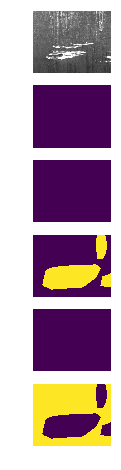

In [7]:
def show_random_data_from_generator(generator):
    tic = time.time()
    sample_img, targs = generator.get_random_batch()
    sample_masks = targs[layer_names['segmentation']]
    print(time.time()-tic)
    sample_img = sample_img*generator.mean_std[1] + generator.mean_std[0]
    print(sample_img.shape, sample_masks.shape)
    fig, axs = plt.subplots(sample_masks.shape[-1] + 1, figsize=(8, 8))
    idx = 0
    axs[0].imshow(np.squeeze(sample_img[idx]))
    axs[0].axis('off')
    for i in range(sample_masks.shape[-1]):
        axs[i+1].imshow(np.squeeze(sample_masks[idx, :, :, i]))
        axs[i+1].axis('off')


show_random_data_from_generator(train_generator)

In [8]:
def softmax_dice_loss(y_true, y_pred):
    return severstal_utils.softmax_dice_loss(y_true, y_pred, alpha=dice_alpha, gumbel_temp=1.)

loss = {layer_names['classification']: 'binary_crossentropy',
        layer_names['auxilliary']: 'categorical_crossentropy',
        layer_names['segmentation']: softmax_dice_loss}

activation=None

In [9]:
def dice_coef_np(y_true, y_pred):
    "Single image only"
    c = y_true.shape[-1]
    y_true_f = np.reshape(y_true, (-1, c))
    y_pred_f =  np.reshape(y_pred, (-1, c))
    intersection = np.sum(y_true_f * y_pred_f, axis=0)
    masksum = np.sum(y_true_f + y_pred_f, axis=0)
    dice = (2.*intersection + 1e-7) / (masksum + 1e-7)
    return dice

In [10]:
import sklearn.metrics as sklm
class Global_Metrics_Callback(keras.callbacks.Callback):
    
    def __init__(self, train_gen, val_gen, writefile):
        super(Global_Metrics_Callback, self).__init__()

        self.tr_gen = train_gen
        self.val_gen = val_gen
        self.num_checks = len(val_gen)
        self.writefile = writefile 
        self.timestart = time.time()
    
    def on_epoch_end(self, epoch, logs={}):
        bsize = self.val_gen.batch_size
        s = self.num_checks * bsize
        
        log = open(self.writefile, 'a+')
        train_metrics, val_metrics = [], []
        for gen, setname, metrics in zip([self.tr_gen, self.val_gen], ['Train', 'Val'], [train_metrics, val_metrics]): 
            ys = np.empty((s, 4), np.int32)
            ps = np.empty((s, 4), np.int32)
            dice = [[], [], [], []]
            for gi in range(self.num_checks):
                x, y = gen[gi]
                y_mask = y[layer_names['segmentation']]
                y_cls = np.int32(y[layer_names['classification']])
                p, cls, _ = self.model.predict_on_batch(x)
                ps[gi*bsize: (gi+1)*bsize, :] = np.int32(cls > 0.5)
                ys[gi*bsize: (gi+1)*bsize, :] = y_cls
                m = severstal_utils.argmax_predictions(p)[..., :-1]
                for bi in range(bsize):
                    dices = dice_coef_np(y_true=y_mask[bi,:,:,:-1], y_pred=m[bi])
                    for ci in range(4):
                        if y_cls[bi,ci]:
                            dice[ci].append(dices[ci])
                        
            
            for c in range(1,4+1):
                if len(dice[c-1]) > 0:
                    dice_c = np.mean(np.array(dice[c-1]))
                else:
                    dice_c = 0.
                tn, fp, fn, tp = sklm.confusion_matrix(ys[:, c-1], ps[:, c-1], labels=[0, 1]).ravel()
                metrics.extend([tp, fp, fn, tn])
                metrics.append(dice_c)
        
        timediff = int(time.time() - self.timestart)
        time_hh_mm = [timediff//3600, (timediff//60)%60]
        lr_1e3 = keras.backend.eval(model.optimizer.lr)*1e3
        writestring = ''
        writestring += '| %0.3f | %02d | %0.5f | %0.5f  ' % (lr_1e3, epoch+1, logs['loss'], logs['val_loss'])
        writestring += '| %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f ' % (\
                        (*train_metrics,))
        writestring += '| %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f  %03d %03d %03d %03d %0.3f ' % (\
                        (*val_metrics,))                                                                                                                
        writestring += '|        %02d  %02d     ' % (*time_hh_mm,)   
        writestring += '| %0.5f | %0.5f  ' % (logs['masks_loss'], logs['val_masks_loss'])
        writestring += '| %0.5f | %0.5f  ' % (logs['classifier_loss'], logs['val_classifier_loss'])
        writestring += '| %0.5f | %0.5f  ' % (logs['auxilliary_segmentation_loss'], logs['val_auxilliary_segmentation_loss'])
        writestring += '|\n'
                       
        log.write(writestring)
        log.close()
        return

checkpoint = ModelCheckpoint(savemodelname, save_best_only=False,  period=4)
metricsCallback = Global_Metrics_Callback(train_gen=train_generator, 
                                           val_gen=val_generator, writefile=logFile)

def lr_linear_schedule(epoch, initial_lr, final_lr, total_epochs):
    new_lr = initial_lr + (final_lr - initial_lr) * epoch / total_epochs
    return new_lr

lrSchedule = LearningRateScheduler(lambda e, lr: lr_linear_schedule(e, *LR_FREEZE,  EPOCHS_FREEZE), 1)

if not dummymode:
    callbacks = [checkpoint, metricsCallback, lrSchedule]
else:
    callbacks = [metricsCallback]

In [11]:
def add_weight_regularization(model, regularizer):
    for layer in model.layers:
        for attr in ['kernel_regularizer']: #, 'bias_regularizer']:
            if hasattr(layer, attr) and layer.trainable:
                setattr(layer, attr, regularizer)

In [12]:
def get_model(encoder_freeze=True):
    effunet = Unet(backbone_name = BACKBONE, input_shape=(*TRAIN_DIM, 3), 
                     encoder_weights='imagenet', 
                     encoder_freeze=encoder_freeze, 
                     classes=5,
                     activation=None,
                     decoder_filters=decoder_filters,
                     output_name='masks', 
                     decoder_activation='swish',
                     decoder_block_type = decoder_block_type)
    
    seghead = effunet.get_layer(auxseg_layername).output
    auxseg = Conv2D(filters=5, kernel_size=(3, 3), 
                    padding='same', use_bias=True,
                    activation='softmax',
                    kernel_initializer='glorot_uniform',
                    name=layer_names['auxilliary'])(seghead)

    x = MaxPooling2D(32)(auxseg)
    poolseg = GlobalAveragePooling2D()(x)
    avgseg = GlobalAveragePooling2D()(auxseg)
    maxseg = GlobalMaxPooling2D()(auxseg)
    x = Concatenate()([maxseg, avgseg, poolseg])
    classifier = Dense(4, activation='sigmoid', name=layer_names['classification'])(x)
    
    model = Model(inputs=effunet.inputs, outputs=[effunet.output, classifier, auxseg])
    
    return model

In [13]:
if not dummymode:
    model = get_model(encoder_freeze=True)

    add_weight_regularization(model, regularizer=keras.regularizers.l2(WEIGHT_DECAY))

    adam = Adam(LR_FREEZE[0])
    model.compile(optimizer=adam, loss=loss)

    if os.path.exists(loadmodelname):
        model.load_weights(loadmodelname)
    model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 320, 3)  0                                            
__________________________________________________________________________________________________
stem_conv (Conv2D)              (None, 128, 160, 48) 1296        input_1[0][0]                    
__________________________________________________________________________________________________
stem_bn (BatchNormalization)    (None, 128, 160, 48) 192         stem_conv[0][0]                  
__________________________________________________________________________________________________
stem_activation (Activation)    (None, 128, 160, 48) 0           stem_bn[0][0]                    
____________________

Total params: 27,683,810
Trainable params: 10,132,634
Non-trainable params: 17,551,176
__________________________________________________________________________________________________


In [14]:
if not dummymode:
    history = model.fit_generator(
        train_generator,
        validation_data=val_generator,
        callbacks=callbacks,
        use_multiprocessing=False,
        workers=1,
        epochs=EPOCHS_FREEZE, 
        verbose=1
    )

Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.
Epoch 1/30

Epoch 00001: LearningRateScheduler setting learning rate to 0.003.


KeyboardInterrupt: 

In [ ]:
if not dummymode:
    model.save(savemodelname)

In [ ]:
# Reduce batch size due to memory constraint
train_generator, val_generator = get_data_generators(batch_size=BATCH_SIZE//2)

In [ ]:
if EPOCHS_FULL > 0:
    model = get_model(encoder_freeze=False)

    regularizer = keras.regularizers.l2(WEIGHT_DECAY)
    add_weight_regularization(model, regularizer)

    adam = Adam(LR_FULL[0])
    model.compile(optimizer=adam, loss=loss)

    if os.path.exists(savemodelname):
        model.load_weights(savemodelname)
    elif os.path.exists(loadmodelname):
        print("Loading", loadmodelname)
        model.load_weights(loadmodelname)
    if dummymode:
        model.summary()

In [ ]:
if EPOCHS_FULL > 0:
    if not dummymode:
        lrSchedule = LearningRateScheduler(lambda e, lr: lr_linear_schedule(e, *LR_FULL,  EPOCHS_FULL), 1)
        callbacks[-1] = lrSchedule

    history = model.fit_generator(
        train_generator,
        validation_data=val_generator,
        callbacks=callbacks,
        use_multiprocessing=False,
        workers=1,
        epochs=EPOCHS_FULL, 
        verbose=1
    )

In [ ]:
if not dummymode:
    model.save(savemodelname)

In [15]:
if not dummymode:
    from numba import cuda

    keras.backend.clear_session()
    cuda.select_device(0)
    cuda.close()